# Assignment 2

<span style="color:red"> Compulsory: 19.5/20; optional: 5/5; overall: 20/20</span>


This assignment investigates deterministic signals and the design of digital filters.
To do this assignement we need a Python 3 distribution with the following libraries:

In [1]:
# import numpy for array manipulation and fft
import numpy as np
# import filtering functionalities from scipy.signal
from scipy.signal import lfilter, filtfilt, butter, freqz
# plotting functionalities
import matplotlib.pyplot as plt

from cmath import phase

If you want to give back the assignement as a jupyter notebook, the following command triggers inline plot.

In [2]:
%matplotlib inline

## Part 1: Multi-frequency signal

We create a function to generate a signal with multiple frequency peaks at multiple locations in time. It will be sum of time-frequency atom functions $x_k$ of the form 
$$
x_{\mu_k,\sigma_k,a_k,f_k}=a_k \cos (2 \pi f_k t)e^{\frac{-(t-\mu_k)^2}{2\sigma_k^2}}
$$

**Question** 1-a: Based on the lecture (Fourier transform of a Gaussian and calculation rules), give the analytical expression of the Fourier transform of such atom. <span style="color:red"> *(2/2)*</span>

<img src="q1.jpg" align="left" width=800 height=600 />

Now we will use the following routine to generate such signal.

In [3]:
def gaussSig(mus,sigmas,amps,freqs,t):
    '''
    Generate a signal based on time frequency atoms:
    Arguments:
    - mus: list/array of time locations
    - sigmas: list/array of temporal widths
    - amps: list/array of amplitudes
    - freqs: list/array of frequency locations
    - t: 1D array of time points
    
    Output:
    - fct: signal evaluated at the given time points
    '''
    fct = 0
    for i in range(len(mus)):
        fct += amps[i]*np.cos(2.*np.pi*freqs[i]*(t))*np.exp(- (t - mus[i])**2/(sigmas[i])**2/2)
    return fct


In [4]:
def gaussSig_analytical(mus,sigmas,amps,freqs,f):
    '''
    Generate a signal based on time frequency atoms:
    Arguments:
    - mus: list/array of time locations
    - sigmas: list/array of temporal widths
    - amps: list/array of amplitudes
    - freqs: list/array of frequency locations
    - f: 1D array of frequency points
    
    Output:
    - fct: signal evaluated at the given time points
    '''
    fct = 0
    for i in range(len(mus)):
        fct += amps[i]*np.sqrt(2*np.pi*sigmas[i]**2)/2*(np.exp(-2*np.pi**2*(f-freqs[i])**2*sigmas[i]**2-1j*2*np.pi*(f-freqs[i])*mus[i])+np.exp(-2*np.pi**2*(f+freqs[i])**2*sigmas[i]**2-1j*2*np.pi*(f+freqs[i])*mus[i]))
    return fct

And use the following signal $x(t)$, sum of 3 time-frequency atoms.

Text(0.5, 0, 'time (s)')

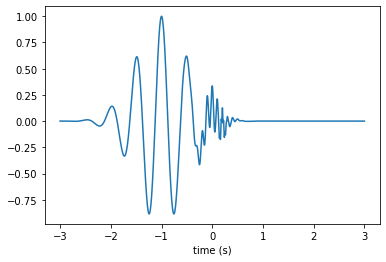

In [5]:
dt=.001;
t = np.arange(-3,3,dt)
mus=[-1,0,.2]
sigmas=[.5,.2,.05]
amps=[1, .2 ,.05]
freqs=[2.,10.,40.]
x = gaussSig(mus,sigmas,amps,freqs,t)
plt.plot(t,x)
plt.xlabel('time (s)')


**Question** 1-b: compute and plot the estimate of the modulus of the continuous time Fourier transform of such signal based on the work done in assignement 0 (using the FFT algorithm). In particular, use a frequency axis in Hz units. Use logrithmic scale if appropriate, and focus the plot on the relevant part of the positive frequency axis. Compare to the theoretical prediction, what may cause the differences? <span style="color:red"> *(2/2)*</span>

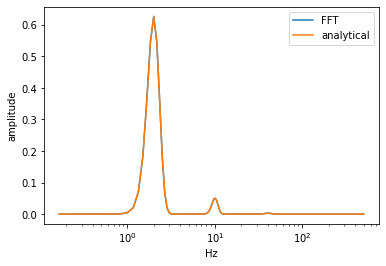

In [6]:
fft_x = np.fft.fft(x)
freq_x = np.fft.fftfreq(t.shape[-1],dt)
freq_x_pos = freq_x[freq_x>0]
fft_x_pos = fft_x[freq_x>0]*dt

# compute analytical response
analytical_x = gaussSig_analytical(mus,sigmas,amps,freqs,freq_x_pos)

# plot
plt.figure(figsize=(6,4))
plt.semilogx(freq_x_pos,np.abs(fft_x_pos),label = 'FFT')
plt.semilogx(freq_x_pos,np.abs(analytical_x),label = 'analytical')
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.legend()
plt.show()

The result of FFT algorithm matches the theoretical prediction.

In [7]:
print('Compare the results:')
for i in range(len(freqs)):
    print('frequency = ',freqs[i], ',FFT amplitude = ',np.abs(fft_x_pos[freq_x_pos==freqs[i]]),', predicted amplitude = ', np.abs(analytical_x[freq_x_pos==freqs[i]]))

Compare the results:
frequency =  2.0 ,FFT amplitude =  [0.62663543] , predicted amplitude =  [0.62665707]
frequency =  10.0 ,FFT amplitude =  [0.05013198] , predicted amplitude =  [0.05013257]
frequency =  40.0 ,FFT amplitude =  [0.00313341] , predicted amplitude =  [0.00313329]


## Part 2: Basic filter example
We now apply a filter to $x(t)$ using the lfilter function.

In [8]:
help(lfilter)

Help on function lfilter in module scipy.signal.signaltools:

lfilter(b, a, x, axis=-1, zi=None)
    Filter data along one-dimension with an IIR or FIR filter.
    
    Filter a data sequence, `x`, using a digital filter.  This works for many
    fundamental data types (including Object type).  The filter is a direct
    form II transposed implementation of the standard difference equation
    (see Notes).
    
    Parameters
    ----------
    b : array_like
        The numerator coefficient vector in a 1-D sequence.
    a : array_like
        The denominator coefficient vector in a 1-D sequence.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        An N-dimensional input array.
    axis : int, optional
        The axis of the input data array along which to apply the
        linear filter. The filter is applied to each subarray along
        this axis.  Default is -1.
    zi : array_like, optional
        Initial conditions for th

We filter the atom signal with a FIR filter by computing the "numeric derivative"
$$
y[n]=x[n]-x[n-1]=(h_1 * x) [n]
$$.

**Question** 2-a. Write down the transfer function $H(z)$ in the z-domain. Implement the filter with the function *lfilter*. Plot the filtered signal together with the original signal for comparison. Use the notion of "numeric derivative" to interpret the effect of the filter on each time-frequency atom of the input signal (lag? amplitude rescaling?). <span style="color:red"> *(1.5/2)*</span> 

<span style="color:red"> *intepretations?*</span>

<img src="q2a.jpg" align="left" width=600 height=600 />

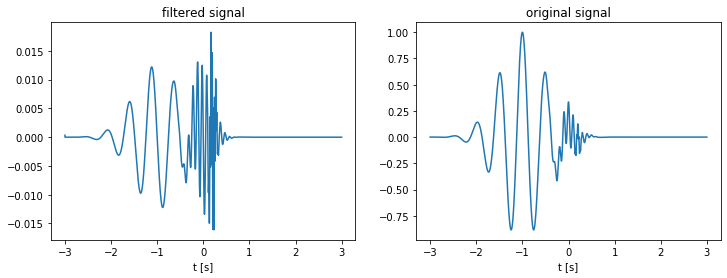

In [9]:
a = [1]
b = [1,-1]
r = lfilter(b,a,x)

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(t,r)
plt.xlabel('t [s]')
plt.title('filtered signal')
plt.subplot(1,2,2)
plt.plot(t,x)
plt.xlabel('t [s]')
plt.title('original signal')
plt.show()


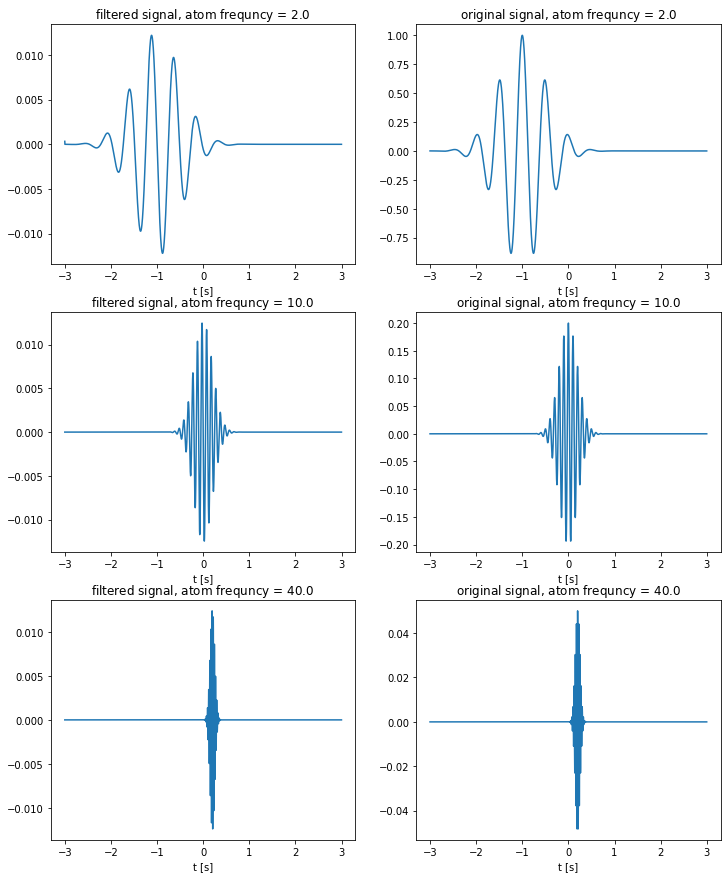

In [10]:
a = [1]
b = [1,-1]

mus=[-1,0,.2]
sigmas=[.5,.2,.05]
amps=[1, .2 ,.05]
freqs=[2.,10.,40.]

atom_x=[]
atom_r=[]
for i in range(len(mus)):
    atom = amps[i]*np.cos(2.*np.pi*freqs[i]*(t))*np.exp(- (t - mus[i])**2/(sigmas[i])**2/2)
    atom_x.append(atom)
    atom_r.append(lfilter(b,a,atom))

# plot
plt.figure(figsize=(12,15))
cur=1
for i in range(len(mus)):
    plt.subplot(3,2,cur)
    plt.plot(t,atom_r[i])
    plt.xlabel('t [s]')
    plt.title(f'filtered signal, atom frequncy = ${freqs[i]}$')
    cur+=1
    plt.subplot(3,2,cur)
    plt.plot(t,atom_x[i])
    plt.xlabel('t [s]')
    plt.title(f'original signal, atom frequncy = ${freqs[i]}$')
    cur+=1
plt.show()


**Question** 2-b. Derive the analytical form of the frequency response of the FIR filter in the form of $H(e^{i\omega})=|H(e^{i\omega})|e^{i\phi(\omega)},\,\omega=2\pi \nu$. From the expression of $|H(e^{i\omega})|$ explain whether the filter is a low-pass filter or a high-pass filter. Check the result with the Fourier transform of the filtered signal compared with that of the original signal. From the expression of $e^{i\phi(\omega)}$ do we retrieve the interpretation of the filter as performing a derivative? What is the difference with repect to the true derivative operation on a continuous signal? <span style="color:red"> *(2/2)*</span>

<img src="q2b.jpg" align="left" width=600 height=600 />

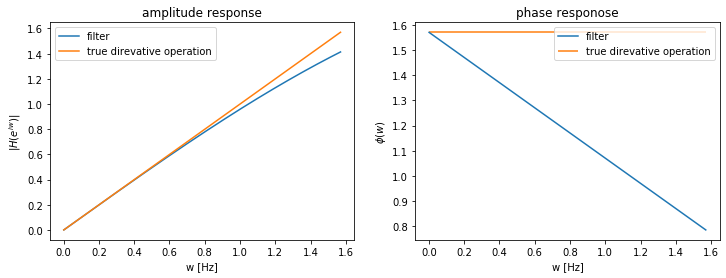

In [11]:
w = np.arange(0.001,np.pi/2,0.001)
amplitude_r = np.sqrt(2*(1-np.cos(w)))
phase_r = np.arctan2(np.sin(w),1-np.cos(w))

# plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(w,amplitude_r,label='filter')
plt.plot(w,w,label='true direvative operation')
plt.xlabel('w [Hz]')
plt.ylabel('$|H(e^{iw})|$')
plt.legend()
plt.title('amplitude response')
plt.subplot(1,2,2)
plt.plot(w,phase_r,label='filter')
plt.hlines(np.pi/2,min(w),max(w),color='C1',label='true direvative operation')
plt.xlabel('w [Hz]')
plt.ylabel('$\phi(w)$')
plt.title('phase responose')
plt.legend()
plt.show()

From the expression of $|H(e^{i\omega})|$, it is a 'high pass' filter, that keeps the high frequency components and attennuates low frequency components. The phase response of the true derivative operation on a continous signal is $\frac{\pi}{2}$ for all frequencies. But the phase response of this filter shows a decay from $\frac{\pi}{2}$ for high frequency components, so we can't retrieve the interpretation of the filter as performing a derivative.

## Part 3: Butterworth filters
We will now illustrate band-pass filtering using Infinite Impulse Response filters (IIR). More specifically, we will use the Butterworth filter design routine of the scipy.signal toolbox. This type of filter design is based on a familly of analog (continuous time) filter that can be converted to the digital filters using a specific transformation. One interest of these filters that they require much less coefficients than FIR filters to implement a sharp frequency response due to their recursivity.

In [12]:
help(butter)

Help on function butter in module scipy.signal.filter_design:

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
    Butterworth digital and analog filter design.
    
    Design an Nth-order digital or analog Butterworth filter and return
    the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    Wn : array_like
        A scalar or length-2 sequence giving the critical frequencies.
        For a Butterworth filter, this is the point at which the gain
        drops to 1/sqrt(2) that of the passband (the "-3 dB point").
    
        For digital filters, `Wn` are in the same units as `fs`.  By default,
        `fs` is 2 half-cycles/sample, so these are normalized from 0 to 1,
        where 1 is the Nyquist frequency.  (`Wn` is thus in
        half-cycles / sample.)
    
        For analog filters, `Wn` is an angular frequency (e.g. rad/s).
    btype : {'lowpass', 'highpass', 'bandpass', 'bandstop'}, optional
        The t

**Question** 3-a. Define a 3-order bandpass Butterworth filter for the band 8-12Hz to select the 10Hz frequency. Plot the coefficients of the filter as well as the filtered signals . Note the special convention: the frequency parameters 
are normalized using **half** the sampling frequency!!. <span style="color:red"> *(.5/1)*</span>

<span style="color:red"> *filtered signal?*</span>

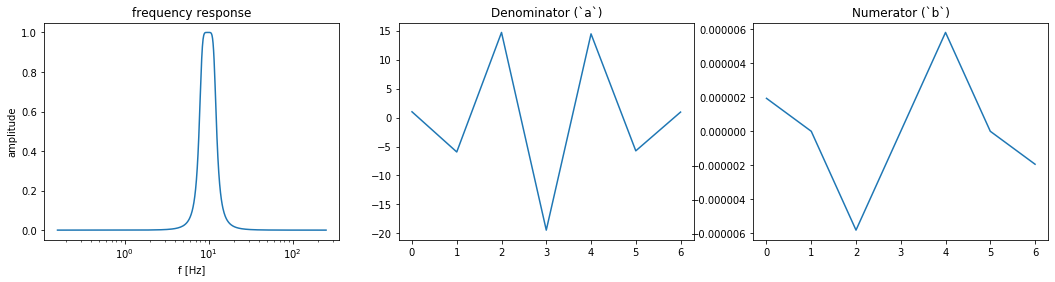

In [13]:
Fs = 1/dt  # sampling frequency
nyq = 0.5 * Fs  # nyquist frequency
lowcut = 8/nyq
highcut = 12/nyq
order = 3
b, a = butter(order, [lowcut,highcut], 'bandpass')
w1, h = freqz(b=b, a=a, worN=w)

# plot
plt.figure(figsize=(18,4))
plt.subplot(1,3,2)
plt.plot(a)
plt.title('Denominator (`a`)')
plt.subplot(1,3,3)
plt.plot(b)
plt.title('Numerator (`b`)')       
plt.subplot(1,3,1)
plt.semilogx(w1/(2*np.pi*dt),np.abs(h))
plt.xlabel('f [Hz]')
plt.ylabel('amplitude')
plt.title('frequency response')
plt.show()

The order parameter affects how rapidly the frequencies outside the passband are attenuated 
(as a function of the distance to the passband). For example, selecting a smaller order results in more prominent peaks for the lowest and largest input frequencies.

**Question** 3-b. Repeat the design of IIR filter in Question 3-a with an order of 2. Plot the modulus of the Fourier transform of the unfiltered signal and the filtered signals with the order of 2 and 3. Also try the 20-order filter, what happens then, and why (qualitatively)? <span style="color:red"> *(2/2)*</span>

In [43]:
# calculate fourier transform
def FT (x,t=np.arange(-3,3,dt),dt=0.001):
    # signal = x
    fft_x = np.fft.fft(x)
    freq_x = np.fft.fftfreq(t.shape[-1],dt)
    freq_x_pos = freq_x[freq_x>0]
    fft_x_pos = fft_x[freq_x>0]*dt
    return freq_x_pos,fft_x_pos

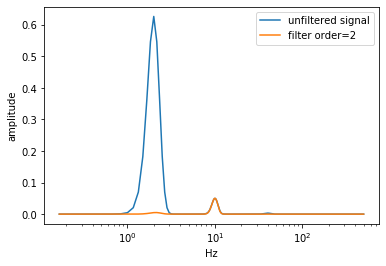

In [44]:
order = 2
b, a = butter(order, [lowcut,highcut], 'bandpass')
x = gaussSig(mus,sigmas,amps,freqs,t)
r_order2 = lfilter(b,a,x)
freq_x, fft_x = FT(r_order2)
# plot
plt.figure(figsize=(6,4))
plt.semilogx(freq_x_pos,np.abs(fft_x_pos),label = 'unfiltered signal')
plt.semilogx(freq_x,np.abs(fft_x),label = 'filter order=2')
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.legend()
plt.show()


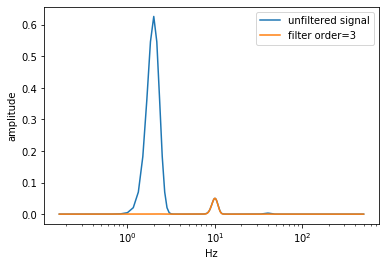

In [40]:
order = 3
b, a = butter(order, [lowcut,highcut], 'bandpass')
x = gaussSig(mus,sigmas,amps,freqs,t)
r_order2 = lfilter(b,a,x)
freq_x, fft_x = FT(r_order2)
# plot
plt.figure(figsize=(6,4))
plt.semilogx(freq_x_pos,np.abs(fft_x_pos),label = 'unfiltered signal')
plt.semilogx(freq_x,np.abs(fft_x),label = 'filter order=3')
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.legend()
plt.show()


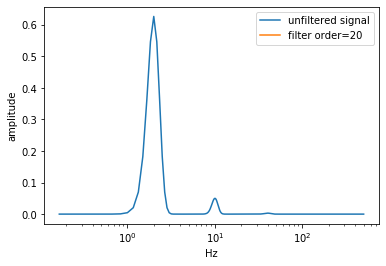

In [41]:
order = 20
b, a = butter(order, [lowcut,highcut], 'bandpass')
x = gaussSig(mus,sigmas,amps,freqs,t)
r_order20 = lfilter(b,a,x)
freq_x, fft_x = FT(r_order20)
# plot
plt.figure(figsize=(6,4))
plt.semilogx(freq_x_pos,np.abs(fft_x_pos),label = 'unfiltered signal')
plt.semilogx(freq_x,np.abs(fft_x),label = 'filter order=20')
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.legend()
plt.show()

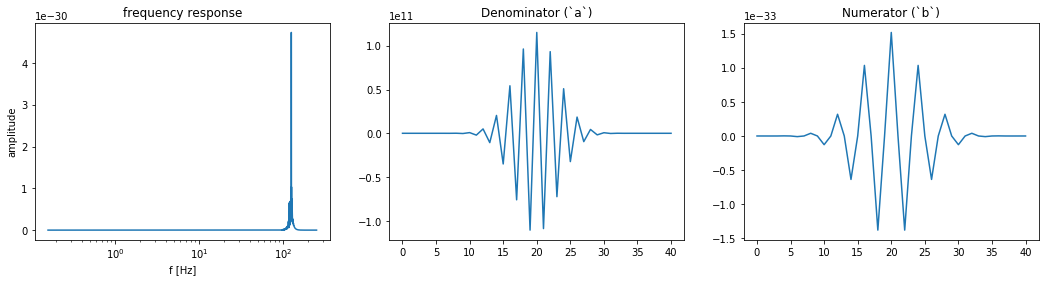

In [19]:
order = 20
b, a = butter(order, [lowcut,highcut], 'bandpass')
w1, h = freqz(b=b, a=a, worN=w)

# plot
plt.figure(figsize=(18,4))
plt.subplot(1,3,2)
plt.plot(a)
plt.title('Denominator (`a`)')
plt.subplot(1,3,3)
plt.plot(b)
plt.title('Numerator (`b`)')       
plt.subplot(1,3,1)
plt.semilogx(w1/(2*np.pi*dt),np.abs(h))
plt.xlabel('f [Hz]')
plt.ylabel('amplitude')
plt.title('frequency response')
plt.show()

Higher order Butterworth filters have poles closer to the unit circle. This nearby infinite gain point increases the likelihood of numerical instabilities. (e.g. rounding/arithmetic/quantization noise may move a pole to the “wrong” side of the unit circle.) 
cite: https://dsp.stackexchange.com/questions/46797/what-is-the-largest-safe-order-for-the-digital-butterworth-filter-of-a-given-s

The filter correctly extracts the middle frequency oscillation (10 Hz), however we can observe a lag between the original and the filtered pattern due to the fact that the filter is causal. A way to correct for the phase is to apply the filter twice, one forward, one backwards.

**Question** 3-c: for an arbitrary **real-valued** impulse response $h$, consider the (discrete time) LTI system with impulse response $h*h_\sigma$, convolving $h$ with $h_\sigma[k]=h[-k]$. Compute the frequency response of this system and deduce that it applies a zero-phase lag to any input frequency. <span style="color:red"> *(2/2)*</span>

Such "zero-phase filter" can be implemented using the routine filtfilt.

Cite: https://www.youtube.com/watch?v=ue4ba_wXV6A

<img src="q3c1.jpg" align="left" width=600 height=600 />

<img src="q3c2.jpg" align="left" width=600 height=600 />

In [20]:
help(filtfilt)

Help on function filtfilt in module scipy.signal.signaltools:

filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad', irlen=None)
    Apply a digital filter forward and backward to a signal.
    
    This function applies a linear digital filter twice, once forward and
    once backwards.  The combined filter has zero phase and a filter order
    twice that of the original.
    
    The function provides options for handling the edges of the signal.
    
    Parameters
    ----------
    b : (N,) array_like
        The numerator coefficient vector of the filter.
    a : (N,) array_like
        The denominator coefficient vector of the filter.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        The array of data to be filtered.
    axis : int, optional
        The axis of `x` to which the filter is applied.
        Default is -1.
    padtype : str or None, optional
        Must be 'odd', 'even', 'constant', or None.  

**Question** 3-d. Apply *filtfilt*  to the Butterworth filter designed in Question 3-a to filter the atom signal. Plot the filtered signals, and the modulus (in semilogy scale) of its Fourier transform and compare the difference with the performance of *lfilter*. Interpret in line with the above theory question.  <span style="color:red"> *(2/2)*</span>

In [42]:
# filter the signal
order = 3
b, a = butter(order, [lowcut,highcut], 'bandpass')
r_filtfilt = filtfilt(b,a,x)
r_lfilter = lfilter(b,a,x)
r_lfilter_lfilter = lfilter(b,a,r_lfilter)

# calulate the modulus (in semilogy scale) of its Fourier transform 
freq_x_filtfilt, fft_x_filtfilt = FT(r_filtfilt)
freq_x_lfilter, fft_x_lfilter = FT(r_lfilter)
freq_x_lfilter_lfilter, fft_x_lfilter_lfilter = FT(r_lfilter_lfilter)

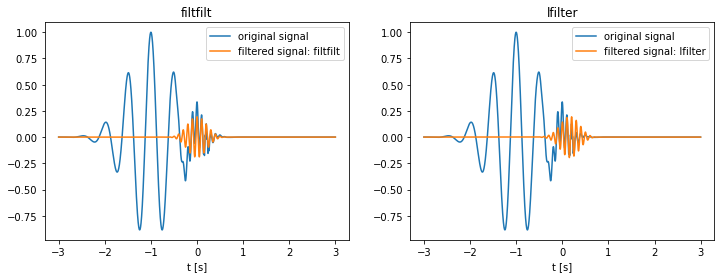

In [22]:
# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x,label = 'original signal')
plt.plot(t,r_filtfilt, label = 'filtered signal: filtfilt')
plt.xlabel('t [s]')
plt.title('filtfilt')
plt.legend()
plt.subplot(122)
plt.plot(t,x,label = 'original signal')
plt.plot(t,r_lfilter, label = 'filtered signal: lfilter')
plt.xlabel('t [s]')
plt.title('lfilter')
plt.legend()
plt.show()

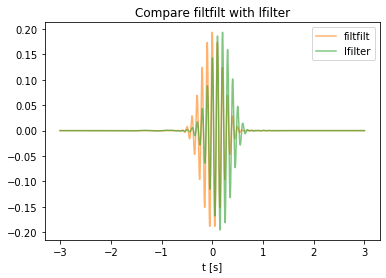

In [23]:
# plot : Compare filtfilt with lfilter
plt.figure(figsize=(6,4))
plt.plot(t,r_filtfilt, color='C1',alpha=0.6,label = 'filtfilt')
plt.plot(t,r_lfilter, color='C2',alpha=0.6,label = 'lfilter')
plt.xlabel('t [s]')
plt.title('Compare filtfilt with lfilter')
plt.legend()
plt.show()

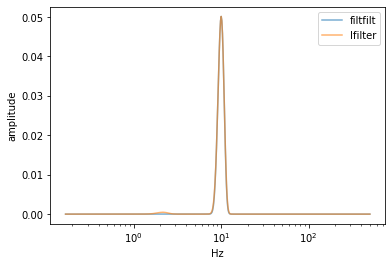

In [24]:
# plot: the modulus (in semilogy scale) of its Fourier transform 
plt.figure(figsize=(6,4))
plt.semilogx(freq_x_filtfilt,np.abs(fft_x_filtfilt),alpha=0.6,label = 'filtfilt')
plt.semilogx(freq_x_lfilter,np.abs(fft_x_lfilter),alpha=0.6,label = 'lfilter')
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.legend()
plt.show()

In [25]:
print('frequency = 10, amplitude (filtfilt)= ', np.abs(fft_x_filtfilt[freq_x_filtfilt==10]))
print('frequency = 10, amplitude (lfilter)= ', np.abs(fft_x_lfilter[freq_x_lfilter==10]))
print('frequency = 10, amplitude (lfilter twice)= ', np.abs(fft_x_lfilter_lfilter[freq_x_lfilter_lfilter==10]))

frequency = 10, amplitude (filtfilt)=  [0.05013226]
frequency = 10, amplitude (lfilter)=  [0.05013195]
frequency = 10, amplitude (lfilter twice)=  [0.05013192]


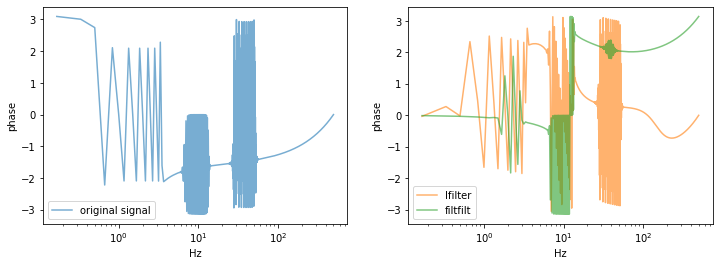

In [26]:
def phase_finder(x):
    out=[]
    for i in range(len(x)):
        out.append(phase(x[i]))
    return out
# plot: phase 
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogx(freq_x_pos,phase_finder(fft_x_pos),alpha=0.6,label = 'original signal')
plt.xlabel('Hz')
plt.ylabel('phase')
plt.legend()
plt.subplot(1,2,2)
plt.semilogx(freq_x_lfilter,phase_finder(fft_x_lfilter),'C1',alpha=0.6,label = 'lfilter')
plt.semilogx(freq_x_filtfilt,phase_finder(fft_x_filtfilt),'C2',alpha=0.6,label = 'filtfilt')
plt.xlabel('Hz')
plt.ylabel('phase')
plt.legend()
plt.show()

For regions near 10 Hz, the phase response after filtfilt is more consistent with the phase response of original signal. 

Now we illustrate an important consequence of the *Heisenberg's uncertainty principle* on filter design. 

**Question** 3-e. Assume we want to be more selective and make the selected frequency band narrower. Design a bandpass Butterworth filter as in Question 3-a but with a narrower passband width (1Hz). Apply the filter to the atom signal and plot the filtered signal in comparison to the original signal. Explain qualitatively why the filtered waveform at 10Hz is less localized in time. <span style="color:red"> *(2/2)*</span>

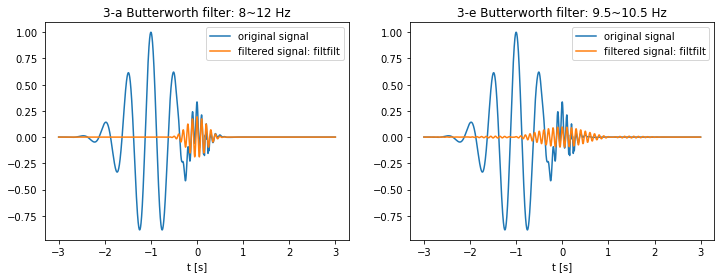

In [27]:
lowcut = 9.5/nyq
highcut = 10.5/nyq
order = 3
b, a = butter(order, [lowcut,highcut], 'bandpass')
w1, h = freqz(b=b, a=a, worN=w)
r_filtfilt_band1 = filtfilt(b,a,x)

# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x,label = 'original signal')
plt.plot(t,r_filtfilt, label = 'filtered signal: filtfilt')
plt.xlabel('t [s]')
plt.title('3-a Butterworth filter: 8~12 Hz')
plt.legend()
plt.subplot(122)
plt.plot(t,x,label = 'original signal')
plt.plot(t,r_filtfilt_band1, label = 'filtered signal: filtfilt')
plt.xlabel('t [s]')
plt.title('3-e Butterworth filter: 9.5~10.5 Hz')
plt.legend()
plt.show()

Heisenberg’s Uncertainty Principle states that one (often, but not always) cannot know all things about a particle (as it is defined by it’s wave function) at the same time. cite: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Quantum_Mechanics/02._Fundamental_Concepts_of_Quantum_Mechanics/Heisenberg's_Uncertainty_Principle
<br><br>
In 3-a, there is more unecrtainty in the frequency domain thus less uncertainty in the time domain.<br>
In 3-e, there is less uncertainty in the frequency domain so more uncertainty in the time domain. 

**Question** 3-f (*optional*). Evaluate numerically and plot the impulse response of the butterworth filters of questions 3-a and 3-b. Interpret the overal shape and differences between them. <span style="color:red"> *(3/3)*</span>

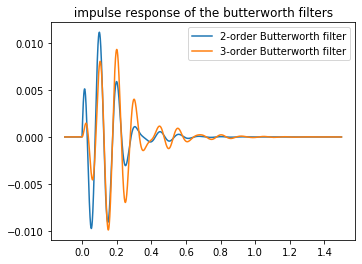

In [28]:
delta = np.zeros(1600)
delta[100]=1

lowcut = 8/nyq
highcut = 12/nyq
order = 3
b3, a3 = butter(order, [lowcut,highcut], 'bandpass')
r3 = lfilter(b3,a3,delta)

order = 2
b2, a2 = butter(order, [lowcut,highcut], 'bandpass')
r2 = lfilter(b2,a2,delta)

order = 4
b4, a4 = butter(order, [lowcut,highcut], 'bandpass')
r4 = lfilter(b4,a4,delta)
# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(len(delta))*dt-0.1,r2, label='2-order Butterworth filter')
plt.plot(np.arange(len(delta))*dt-0.1,r3, label='3-order Butterworth filter')
#plt.plot(np.arange(len(delta))*dt-0.1,r4, label='20-order Butterworth filter')
plt.title(' impulse response of the butterworth filters ')
plt.legend()
plt.show()

3-order Butterworth filter peaks later and vanishes later.

## Part 4: Application to sleep patterns analysis
We use filtering to dissociate transient thalamocortical oscillations. For that we use a rate based model of thalamocortical interactions from the paper of Costa et al. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005022

The simulated signal is an average membrane potential of pyramidal populations in both cortex and thalamus. Noticable transient patterns are spindles (~12Hz oscillations), and K-Complexes (transient low-frequency deflection).

We first import the data in the mat file `thactx_rhythms.mat` uploaded from https://owncloud.tuebingen.mpg.de/index.php/s/HHdAcKzn3Jcdoap

In [70]:
# Use h5py to import mat files and convert to numpy array
#import h5py
#Vctx = f.get('Vctx') # convert data to np array
#Vctx = np.array(Vctx)
#Vtha = f.get('Vtha') # convert data to np array
#Vtha = np.array(Vtha)
#dX = f.get('dX') # convert data to np array
#dX = np.array(dX)
#dX = dX[0]

# or use hdf5storage (h5py not working in recent versions)
import hdf5storage
f = hdf5storage.loadmat('thactx_rhythms.mat')
Vctx = f['Vctx'].T # convert data to np array
Vtha = f['Vtha'].T # convert data to np array
dX = f['dX'] # convert data to np array
dX = dX[0]
dX

array([0.001])

The time series represent the population average of cells membrane potentials, hence the negative offsets. $dX$ represents the sampling period in secs. 

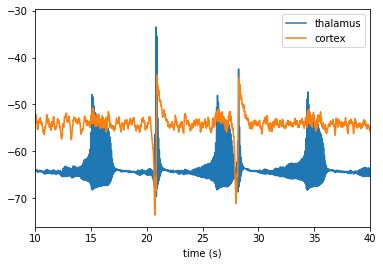

In [74]:
tax = np.arange(Vctx.shape[0])*dX
plt.plot(tax.T,Vtha, label='thalamus')
plt.plot(tax.T,Vctx, label='cortex')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()

The time course shows clearly different transient patterns. The slow frequency wave in cortex, and the higher frequency spindels clearly visible in thalamus. 

**Question** 4-a. Compute and plot the modulus of the Fourier transform of the simulated thalamic and cortical signals (in linear scale). Note that when computing Fourier transform, remove the time average of each signal to avoid the presence of a large peak at zero frequency. Identify (qualitatively) two frequency ranges, one low frequency range $[0,f_l]$ and one frequency band $[f_1,f_2]$ where the power of both signals is concentrated, corresponding the the patterns observed in the above time course. <span style="color:red"> *(1/1)*</span>

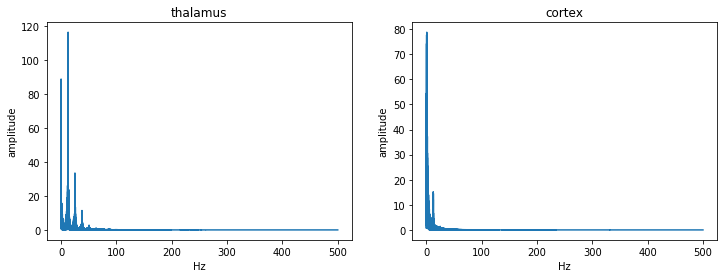

In [62]:
# pre-processing
Vtha = Vtha.squeeze()
Vctx = Vctx.squeeze()
x_Vtha = Vtha-np.mean(Vtha)
x_Vctx = Vctx-np.mean(Vctx)

# calculate frequency response
freq_x_Vtha, fft_x_Vtha = FT(x_Vtha,t=tax.T)
freq_x_Vctx, fft_x_Vctx = FT(x_Vctx,t=tax.T)

# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freq_x_Vtha,np.abs(fft_x_Vtha))
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.title('thalamus')
plt.subplot(122)
plt.plot(freq_x_Vctx,np.abs(fft_x_Vctx))
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.title('cortex')
plt.show()

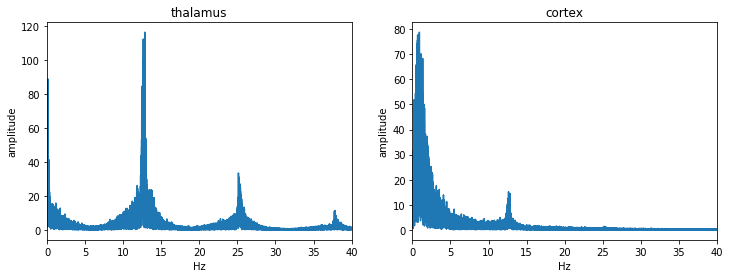

In [64]:
# plot: zoom in
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freq_x_Vtha,np.abs(fft_x_Vtha))
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.title('thalamus')
plt.xlim([0,40])
plt.subplot(122)
plt.plot(freq_x_Vctx,np.abs(fft_x_Vctx))
plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.title('cortex')
plt.xlim([0,40])
plt.show()

Low frequency range [0,5] Hz, might corresponds to K-Complexes (transient low-frequency deflection)<br>
frequency band [10,15] Hz, might corresponds to spindles (~12Hz oscillations)

**Question** 4-b. Following Question 3, use 3-order Butterworth filters to isolate the two types of events in the cortical signal: design a appropriate bandpass filter in $[f_1,f_2]$ to extract the so-called spindle events and a low-pass filter in $[0,f_l]$ for K-complexes. Plot the both filtered signals together with the unfiltered thalamic and cortical signals (one plot for each structure) to observe the temporal relationship between each type of events and the content of the original signals (e.g. can we observe spindles in cortex, when? are different event subtypes?). <span style="color:red"> *(2/2)*</span>


In [65]:
Fs = 1/dX  # sampling frequency
nyq = 0.5 * Fs  # nyquist frequency
f1 = 10/nyq
f2 = 15/nyq
fL = 5/nyq
order = 3
b_spindle, a_spindle = butter(order, [f1,f2], 'bandpass')
b_Kcomplex, a_Kcomplex = butter(order, fL, 'lowpass')

# filter signal: thalamus
r_spindle_tha = filtfilt(b_spindle, a_spindle, x_Vtha)
r_Kcomplex_tha = filtfilt(b_Kcomplex, a_Kcomplex, x_Vtha)

# filter signal: cortex
r_spindle_ctx = filtfilt(b_spindle, a_spindle,x_Vctx)
r_Kcomplex_ctx = filtfilt(b_Kcomplex, a_Kcomplex,x_Vctx)

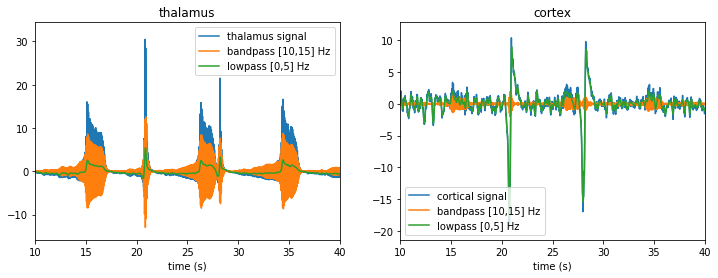

In [77]:
# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tax.T,x_Vtha, label='thalamus signal')
plt.plot(tax.T,r_spindle_tha, label='bandpass [10,15] Hz')
plt.plot(tax.T,r_Kcomplex_tha, label='lowpass [0,5] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('thalamus')
plt.subplot(122)
plt.plot(tax.T,x_Vctx, label='cortical signal')
plt.plot(tax.T,r_spindle_ctx, label='bandpass [10,15] Hz')
plt.plot(tax.T,r_Kcomplex_ctx, label='lowpass [0,5] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('cortex')
plt.show()

Spindle events are more obvious in Thalamus, and K-complexes are more obvious in cortex. <br>
There seems to be spindle events in the cortex, but the amplitude is not large.<br>
K-complexes are transient and spindles are oscillatory.<br>
when there is K-complexes, spindle events seems to follow the K-complex event. 

**Question** 4-c (*optional*). Vary the value of $f_l$, and the band width of $[f_1,f_2]$ around its center frequency. Qualitatively, illustrate the trade offs for the choice of frequencies needed one one hand to separate the different events and on the other hand to obtain filtered signals that respect the overall shape of the time course of the orginal patterns. <span style="color:red"> *(2/2)*</span>


In [78]:
Fs = 1/dX  # sampling frequency
nyq = 0.5 * Fs  # nyquist frequency
f1 = 11/nyq
f2 = 14/nyq
fL = 4/nyq
order = 3
b_spindle, a_spindle = butter(order, [f1,f2], 'bandpass')
b_Kcomplex, a_Kcomplex = butter(order, fL, 'lowpass')

# filter signal: thalamus
r_spindle_tha = filtfilt(b_spindle, a_spindle, x_Vtha)
r_Kcomplex_tha = filtfilt(b_Kcomplex, a_Kcomplex, x_Vtha)

# filter signal: cortex
r_spindle_ctx = filtfilt(b_spindle, a_spindle,x_Vctx)
r_Kcomplex_ctx = filtfilt(b_Kcomplex, a_Kcomplex,x_Vctx)

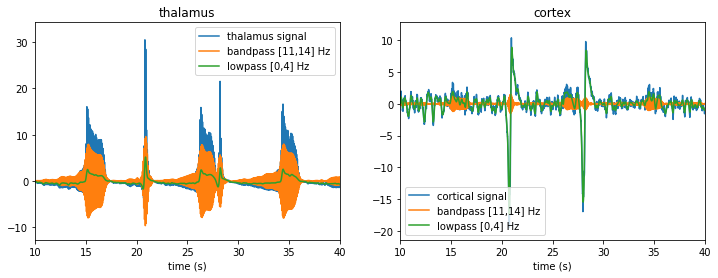

In [80]:
# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tax.T,x_Vtha, label='thalamus signal')
plt.plot(tax.T,r_spindle_tha, label='bandpass [11,14] Hz')
plt.plot(tax.T,r_Kcomplex_tha, label='lowpass [0,4] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('thalamus')
plt.subplot(122)
plt.plot(tax.T,x_Vctx, label='cortical signal')
plt.plot(tax.T,r_spindle_ctx, label='bandpass [11,14] Hz')
plt.plot(tax.T,r_Kcomplex_ctx, label='lowpass [0,4] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('cortex')
plt.show()

In [81]:
Fs = 1/dX  # sampling frequency
nyq = 0.5 * Fs  # nyquist frequency
f1 = 7/nyq
f2 = 20/nyq
fL = 7/nyq
order = 3
b_spindle, a_spindle = butter(order, [f1,f2], 'bandpass')
b_Kcomplex, a_Kcomplex = butter(order, fL, 'lowpass')

# filter signal: thalamus
r_spindle_tha = filtfilt(b_spindle, a_spindle, x_Vtha)
r_Kcomplex_tha = filtfilt(b_Kcomplex, a_Kcomplex, x_Vtha)

# filter signal: cortex
r_spindle_ctx = filtfilt(b_spindle, a_spindle,x_Vctx)
r_Kcomplex_ctx = filtfilt(b_Kcomplex, a_Kcomplex,x_Vctx)

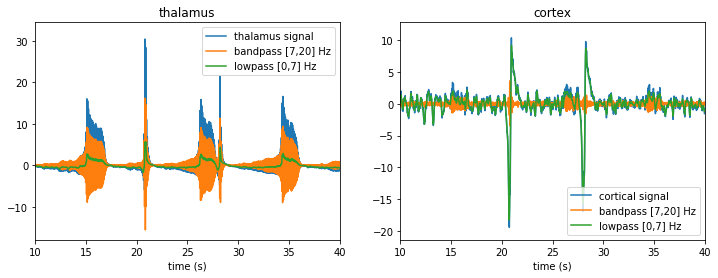

In [82]:
# plot
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tax.T,x_Vtha, label='thalamus signal')
plt.plot(tax.T,r_spindle_tha, label='bandpass [7,20] Hz')
plt.plot(tax.T,r_Kcomplex_tha, label='lowpass [0,7] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('thalamus')
plt.subplot(122)
plt.plot(tax.T,x_Vctx, label='cortical signal')
plt.plot(tax.T,r_spindle_ctx, label='bandpass [7,20] Hz')
plt.plot(tax.T,r_Kcomplex_ctx, label='lowpass [0,7] Hz')
plt.xlim([10,40])
plt.xlabel('time (s)')
plt.legend()
plt.title('cortex')
plt.show()

Due to Heisenberg’s Uncertainty Principle, it is not possible to acheive frequency precision and time precision at the same time. <br>
having a wide bandpass, and large fL allow us to see the temporal correlation between the K-complexes and spindle events.<br>
having a narrower band around the center frequencies, allow us to see the shape of the K-complexes and spindle events more clearly.  
